# Understanding Terms and Metrics in GAN Training

When training a deep learning model, particularly Generative Adversarial Networks (GANs), the following terms and values have specific meanings and calculations:

1. **Epoch**

An Epoch refers to one complete cycle through the entire training dataset, allowing the model to process each training example once. For example, if you have 1000 training samples, then one epoch is when the model has completed training on all 1000 samples.

2. **Step**

A Step usually refers to an iteration, i.e., completing one forward and one backward pass of a batch of data. If you have 1000 samples and your batch size is 10, then one epoch will consist of 100 steps.

3. **Batch**

A Batch is a subset of the training data used for a single iteration. For example, if you have 1000 samples and your batch size is 10, you will have 100 different batches each consisting of 10 samples.

<br>

4. ***d_loss* (Discriminator Loss)**

The loss for the Discriminator is calculated based on its ability to distinguish between real and generated images. In the case of Binary Cross-Entropy Loss, it can be calculated as follows:


$$\mit {d\_loss}=−(log(D(x))+log(1−D(G(z))))$$

- $D(x)$ is the output of the Discriminator for real images,
- $D(G(z))$ is the output of the Discriminator for generated images.

<br>

5. ***g_loss* (Generator Loss)**

The loss for the Generator is calculated based on its ability to deceive the Discriminator. Its goal is to have the generated images classified as real by the Discriminator. In the case of Binary Cross-Entropy Loss, it can be calculated as follows:

$$\mit {g\_loss}=−log(D(G(z)))$$

- $D(G(z))$ is the output of the Discriminator for generated images.

<br>

6. **$D(x)$**

$D(x)$ is the average output of the Discriminator for real images. Theoretically, for real images, this value should be close to 1.

$$D(x)= \frac{1}{N}\sum_{i=1}^{N}D(x_i)$$

- $N$ is the batch size, and $x_i$ is a real image in the batch.


<br>

7. **$D(G(z))$**

$D(G(z))$ is the average output of the Discriminator for generated images. Theoretically, for generated images, this value should be close to 0.

$$D(G(z))= \frac{1}{N}\sum_{i=1}^{N}D(G(z_i))$$

- $N$ is the batch size, and $z_i$ is a noise vector sampled from the latent space.



# Techniques for improving GAN Performance

To enhance the performance and image quality of Generative Adversarial Networks (GANs), various methods can be explored. Here are some suggestions and techniques for refinement:

3.1 **Model Architecture**:
- Deeper Models: Consider using deeper architectures for both the generator and discriminator.
- Convolutional Layers: For image tasks, Convolutional GANs often perform better. Use convolutional layers instead of fully connected ones.

3.2 **Loss Functions**:
- Wasserstein Loss: The Wasserstein GAN utilizes a different loss metric, often improving training stability.
- Gradient Penalty: Alongside Wasserstein GANs, use gradient penalty for further training stabilization.

3.3 **Regularization**:
- Dropout: Including dropout layers in your model can help prevent overfitting.
- Label Smoothing: Using label values slightly less than 1 for real samples can enhance model robustness.

3.4 **Optimization and Learning Rate**:
- Explore other optimizers like RMSprop or SGD.
- Consider learning rate scheduling by gradually reducing the learning rate.

3.5 **Mode Collapse**: To combat lack of diversity in generated images, techniques like mini-batch discrimination can be used.

3.6 **Larger Datasets**: If feasible, train GANs on larger or more diverse datasets.

3.7 **Pretrained Models**: Think about pretraining your model on a larger dataset and then fine-tuning on a specific dataset.

3.8 **Attention Mechanisms**: Introducing attention mechanisms in GANs, such as in Self-Attention GANs, can help the model capture long-range dependencies.

3.9 **GAN Variants**: Look into other GAN structures and techniques like Conditional GAN, CycleGAN, BigGAN, etc.

3.10 **Training Tricks**:

- Alternating Training: It's not always necessary to train the generator and discriminator for the same number of steps. Sometimes, training the discriminator for more steps can be beneficial.
- Early Stopping: If the quality of generated images starts to decline during training, consider halting the training process.

**Evaluation Metrics**: Beyond FID, other metrics like Inception Score (IS), Precision and Recall, etc., can be utilized to gauge the quality of generated images.

## Improved GAN with Convolutional Architecture and Regularization

1. Import Necessary Libraries

2. Set Hyperparameters

3. Prepare the MNIST Dataset
(No changes here.)

In [ ]:
# Step 1: Import Necessary Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
# Step 2: Set Hyperparameters
batch_size = 100
learning_rate = 0.0002
num_epochs = 100

# GPU device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Step 3: Prepare the MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = dsets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)


In [ ]:
# Step 4: Define the Convolutional Generator Network
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Project and reshape
            nn.Linear(100, 256 * 7 * 7),
            nn.ReLU(),
            nn.BatchNorm1d(256 * 7 * 7),
            Reshape(256, 7, 7),  # Correcting the reshaping

            # Convolutional layers
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
# Step 5: Define the Convolutional Discriminator Network with Regularization
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.3)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 7 * 7, 1)  # Adjusted to match the actual input size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


In [ ]:
# Step 6: Initialize Models and Optimizers with Label Smoothing
generator = Generator().to(device)
discriminator = Discriminator().to(device)

real_labels = torch.full((batch_size, 1), 0.9, device=device)  # Use 0.9 instead of 1
fake_labels = torch.zeros(batch_size, 1, device=device)

criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


Epoch [1/100], Step [100/600], d_loss: 0.3924, g_loss: 3.1421, D(x): 0.85, D(G(z)): 0.03
Epoch [1/100], Step [200/600], d_loss: 0.9064, g_loss: 2.4123, D(x): 0.72, D(G(z)): 0.27
Epoch [1/100], Step [300/600], d_loss: 0.8783, g_loss: 1.2095, D(x): 0.53, D(G(z)): 0.12
Epoch [1/100], Step [400/600], d_loss: 0.7686, g_loss: 2.3470, D(x): 0.80, D(G(z)): 0.29
Epoch [1/100], Step [500/600], d_loss: 0.6674, g_loss: 1.6783, D(x): 0.66, D(G(z)): 0.10
Epoch [1/100], Step [600/600], d_loss: 0.5344, g_loss: 2.4568, D(x): 0.78, D(G(z)): 0.10
Epoch [2/100], Step [100/600], d_loss: 0.8676, g_loss: 2.7814, D(x): 0.84, D(G(z)): 0.33
Epoch [2/100], Step [200/600], d_loss: 0.7802, g_loss: 1.5673, D(x): 0.62, D(G(z)): 0.13
Epoch [2/100], Step [300/600], d_loss: 0.7928, g_loss: 1.4834, D(x): 0.58, D(G(z)): 0.10
Epoch [2/100], Step [400/600], d_loss: 0.8222, g_loss: 1.4214, D(x): 0.72, D(G(z)): 0.25
Epoch [2/100], Step [500/600], d_loss: 0.9921, g_loss: 2.0998, D(x): 0.76, D(G(z)): 0.39
Epoch [2/100], Step [

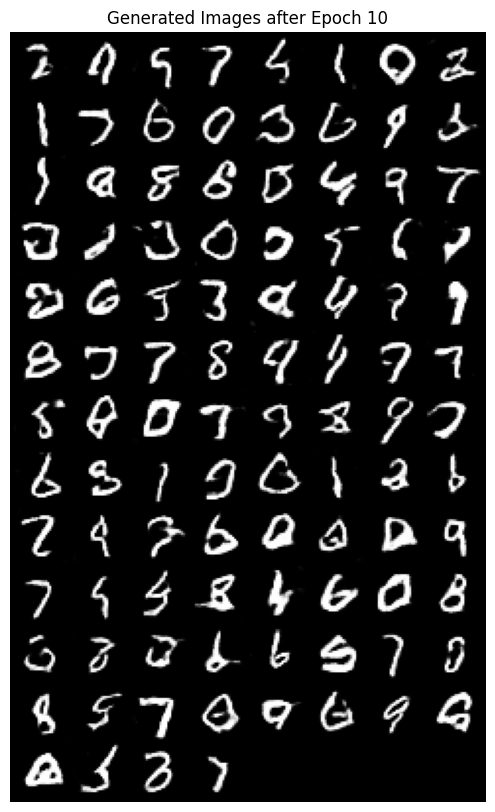

Epoch [11/100], Step [100/600], d_loss: 0.9918, g_loss: 1.0894, D(x): 0.51, D(G(z)): 0.15
Epoch [11/100], Step [200/600], d_loss: 1.0198, g_loss: 1.2660, D(x): 0.64, D(G(z)): 0.32
Epoch [11/100], Step [300/600], d_loss: 1.4116, g_loss: 1.4925, D(x): 0.31, D(G(z)): 0.06
Epoch [11/100], Step [400/600], d_loss: 1.0735, g_loss: 1.3103, D(x): 0.64, D(G(z)): 0.36
Epoch [11/100], Step [500/600], d_loss: 0.9568, g_loss: 1.4966, D(x): 0.68, D(G(z)): 0.32
Epoch [11/100], Step [600/600], d_loss: 1.0896, g_loss: 1.7140, D(x): 0.61, D(G(z)): 0.35
Epoch [12/100], Step [100/600], d_loss: 1.1275, g_loss: 1.1489, D(x): 0.51, D(G(z)): 0.26
Epoch [12/100], Step [200/600], d_loss: 0.9979, g_loss: 1.7102, D(x): 0.70, D(G(z)): 0.35
Epoch [12/100], Step [300/600], d_loss: 1.0622, g_loss: 1.6665, D(x): 0.76, D(G(z)): 0.40
Epoch [12/100], Step [400/600], d_loss: 0.9364, g_loss: 1.4012, D(x): 0.60, D(G(z)): 0.24
Epoch [12/100], Step [500/600], d_loss: 1.1200, g_loss: 1.5754, D(x): 0.43, D(G(z)): 0.16
Epoch [12/

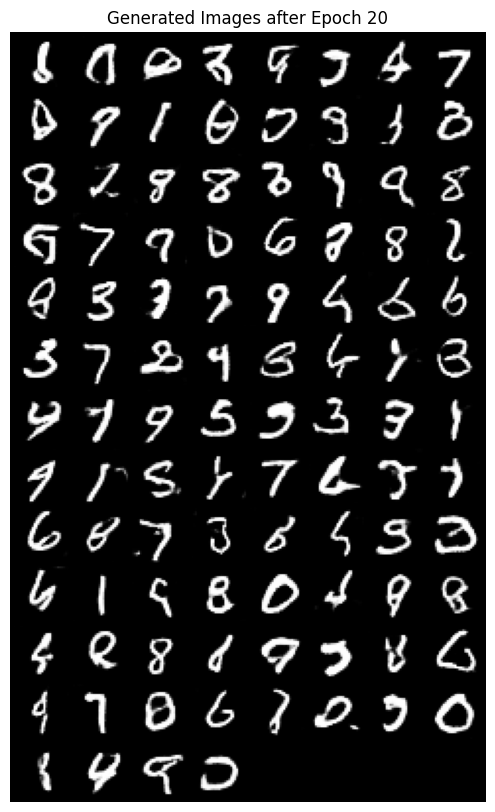

Epoch [21/100], Step [100/600], d_loss: 1.1299, g_loss: 1.0121, D(x): 0.53, D(G(z)): 0.30
Epoch [21/100], Step [200/600], d_loss: 1.2118, g_loss: 0.7589, D(x): 0.55, D(G(z)): 0.37
Epoch [21/100], Step [300/600], d_loss: 1.4466, g_loss: 0.7132, D(x): 0.32, D(G(z)): 0.19
Epoch [21/100], Step [400/600], d_loss: 1.3038, g_loss: 1.8268, D(x): 0.71, D(G(z)): 0.53
Epoch [21/100], Step [500/600], d_loss: 1.1612, g_loss: 0.8615, D(x): 0.51, D(G(z)): 0.32
Epoch [21/100], Step [600/600], d_loss: 1.2990, g_loss: 1.3675, D(x): 0.69, D(G(z)): 0.50
Epoch [22/100], Step [100/600], d_loss: 1.0324, g_loss: 1.0245, D(x): 0.53, D(G(z)): 0.24
Epoch [22/100], Step [200/600], d_loss: 0.9958, g_loss: 1.3949, D(x): 0.65, D(G(z)): 0.33
Epoch [22/100], Step [300/600], d_loss: 1.1999, g_loss: 1.6496, D(x): 0.76, D(G(z)): 0.49
Epoch [22/100], Step [400/600], d_loss: 1.1620, g_loss: 0.9382, D(x): 0.49, D(G(z)): 0.28
Epoch [22/100], Step [500/600], d_loss: 1.1632, g_loss: 1.2147, D(x): 0.63, D(G(z)): 0.43
Epoch [22/

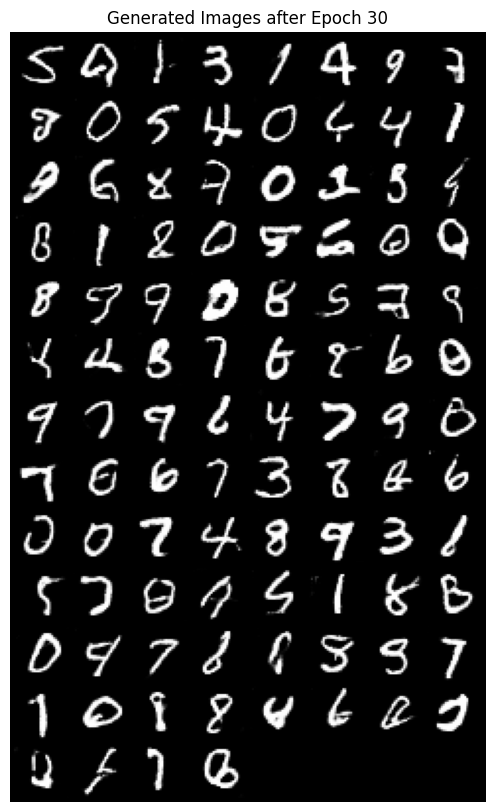

Epoch [31/100], Step [100/600], d_loss: 1.4389, g_loss: 0.9717, D(x): 0.42, D(G(z)): 0.38
Epoch [31/100], Step [200/600], d_loss: 1.2193, g_loss: 1.4203, D(x): 0.51, D(G(z)): 0.35
Epoch [31/100], Step [300/600], d_loss: 1.1970, g_loss: 1.0550, D(x): 0.54, D(G(z)): 0.38
Epoch [31/100], Step [400/600], d_loss: 1.3662, g_loss: 0.8822, D(x): 0.48, D(G(z)): 0.41
Epoch [31/100], Step [500/600], d_loss: 1.2642, g_loss: 1.1814, D(x): 0.57, D(G(z)): 0.44
Epoch [31/100], Step [600/600], d_loss: 1.1867, g_loss: 1.1142, D(x): 0.54, D(G(z)): 0.36
Epoch [32/100], Step [100/600], d_loss: 1.2827, g_loss: 1.0653, D(x): 0.60, D(G(z)): 0.47
Epoch [32/100], Step [200/600], d_loss: 1.2711, g_loss: 0.7400, D(x): 0.40, D(G(z)): 0.27
Epoch [32/100], Step [300/600], d_loss: 1.1913, g_loss: 0.8832, D(x): 0.51, D(G(z)): 0.35
Epoch [32/100], Step [400/600], d_loss: 1.3392, g_loss: 1.1667, D(x): 0.52, D(G(z)): 0.43
Epoch [32/100], Step [500/600], d_loss: 1.2415, g_loss: 0.9652, D(x): 0.50, D(G(z)): 0.36
Epoch [32/

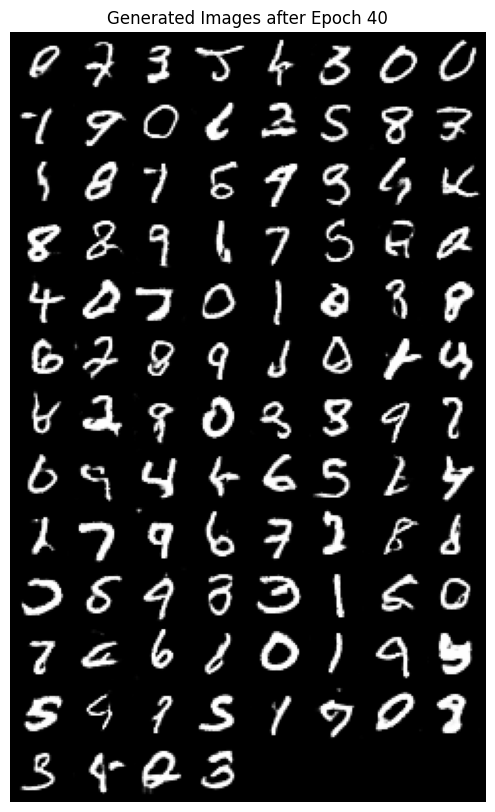

Epoch [41/100], Step [100/600], d_loss: 1.3071, g_loss: 0.7372, D(x): 0.42, D(G(z)): 0.32
Epoch [41/100], Step [200/600], d_loss: 1.2047, g_loss: 0.9643, D(x): 0.56, D(G(z)): 0.41
Epoch [41/100], Step [300/600], d_loss: 1.3457, g_loss: 1.2388, D(x): 0.55, D(G(z)): 0.48
Epoch [41/100], Step [400/600], d_loss: 1.2461, g_loss: 0.8404, D(x): 0.49, D(G(z)): 0.37
Epoch [41/100], Step [500/600], d_loss: 1.2247, g_loss: 0.9014, D(x): 0.50, D(G(z)): 0.37
Epoch [41/100], Step [600/600], d_loss: 1.3777, g_loss: 0.7610, D(x): 0.45, D(G(z)): 0.38
Epoch [42/100], Step [100/600], d_loss: 1.2993, g_loss: 0.8643, D(x): 0.48, D(G(z)): 0.39
Epoch [42/100], Step [200/600], d_loss: 1.2397, g_loss: 0.9682, D(x): 0.49, D(G(z)): 0.37
Epoch [42/100], Step [300/600], d_loss: 1.2266, g_loss: 1.1181, D(x): 0.54, D(G(z)): 0.40
Epoch [42/100], Step [400/600], d_loss: 1.4173, g_loss: 0.9427, D(x): 0.42, D(G(z)): 0.39
Epoch [42/100], Step [500/600], d_loss: 1.2726, g_loss: 0.8639, D(x): 0.46, D(G(z)): 0.36
Epoch [42/

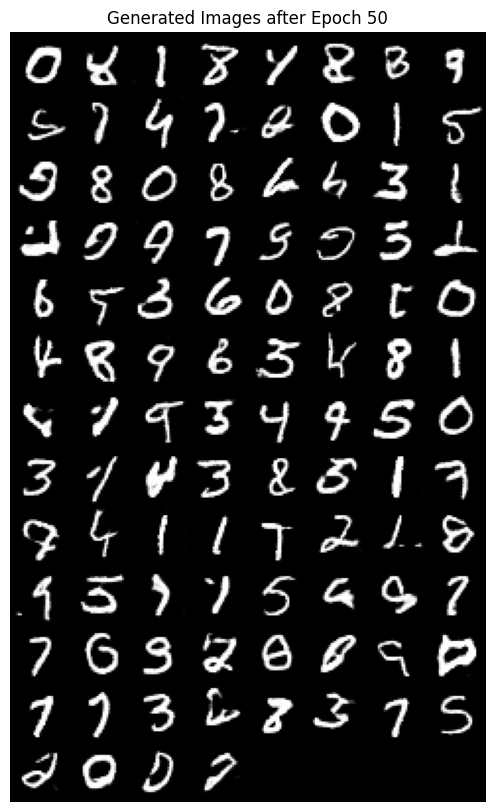

Epoch [51/100], Step [100/600], d_loss: 1.3028, g_loss: 1.1125, D(x): 0.59, D(G(z)): 0.49
Epoch [51/100], Step [200/600], d_loss: 1.2177, g_loss: 1.0317, D(x): 0.54, D(G(z)): 0.40
Epoch [51/100], Step [300/600], d_loss: 1.2617, g_loss: 0.8912, D(x): 0.52, D(G(z)): 0.41
Epoch [51/100], Step [400/600], d_loss: 1.2522, g_loss: 1.0608, D(x): 0.53, D(G(z)): 0.42
Epoch [51/100], Step [500/600], d_loss: 1.5910, g_loss: 0.6981, D(x): 0.31, D(G(z)): 0.34
Epoch [51/100], Step [600/600], d_loss: 1.2715, g_loss: 1.0837, D(x): 0.51, D(G(z)): 0.42
Epoch [52/100], Step [100/600], d_loss: 1.2838, g_loss: 0.9659, D(x): 0.47, D(G(z)): 0.37
Epoch [52/100], Step [200/600], d_loss: 1.2935, g_loss: 0.8211, D(x): 0.49, D(G(z)): 0.40
Epoch [52/100], Step [300/600], d_loss: 1.2820, g_loss: 0.7715, D(x): 0.47, D(G(z)): 0.38
Epoch [52/100], Step [400/600], d_loss: 1.3643, g_loss: 0.9376, D(x): 0.39, D(G(z)): 0.32
Epoch [52/100], Step [500/600], d_loss: 1.3505, g_loss: 0.7274, D(x): 0.45, D(G(z)): 0.40
Epoch [52/

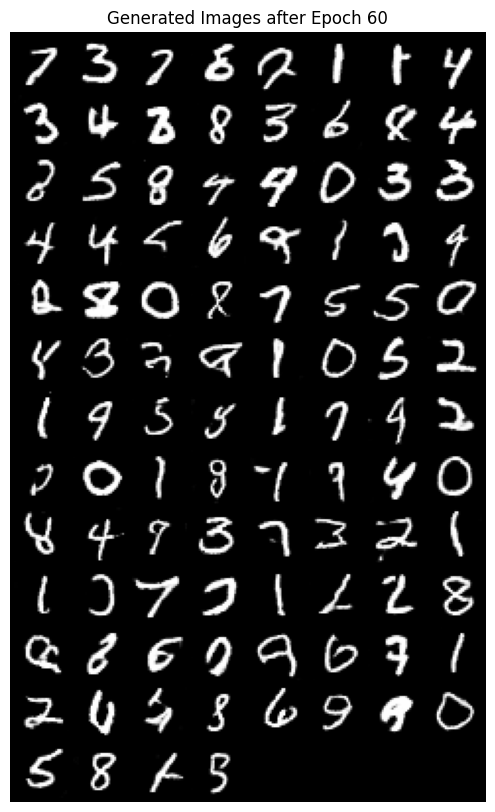

Epoch [61/100], Step [100/600], d_loss: 1.3205, g_loss: 1.1051, D(x): 0.58, D(G(z)): 0.49
Epoch [61/100], Step [200/600], d_loss: 1.1860, g_loss: 1.1462, D(x): 0.57, D(G(z)): 0.42
Epoch [61/100], Step [300/600], d_loss: 1.4718, g_loss: 1.0391, D(x): 0.60, D(G(z)): 0.57
Epoch [61/100], Step [400/600], d_loss: 1.4154, g_loss: 0.8405, D(x): 0.49, D(G(z)): 0.47
Epoch [61/100], Step [500/600], d_loss: 1.3721, g_loss: 1.0964, D(x): 0.61, D(G(z)): 0.54
Epoch [61/100], Step [600/600], d_loss: 1.1935, g_loss: 0.9856, D(x): 0.47, D(G(z)): 0.33
Epoch [62/100], Step [100/600], d_loss: 1.3604, g_loss: 0.9472, D(x): 0.46, D(G(z)): 0.42
Epoch [62/100], Step [200/600], d_loss: 1.2383, g_loss: 1.0036, D(x): 0.54, D(G(z)): 0.42
Epoch [62/100], Step [300/600], d_loss: 1.2883, g_loss: 0.8051, D(x): 0.44, D(G(z)): 0.34
Epoch [62/100], Step [400/600], d_loss: 1.3389, g_loss: 1.0456, D(x): 0.57, D(G(z)): 0.50
Epoch [62/100], Step [500/600], d_loss: 1.3875, g_loss: 0.8732, D(x): 0.48, D(G(z)): 0.45
Epoch [62/

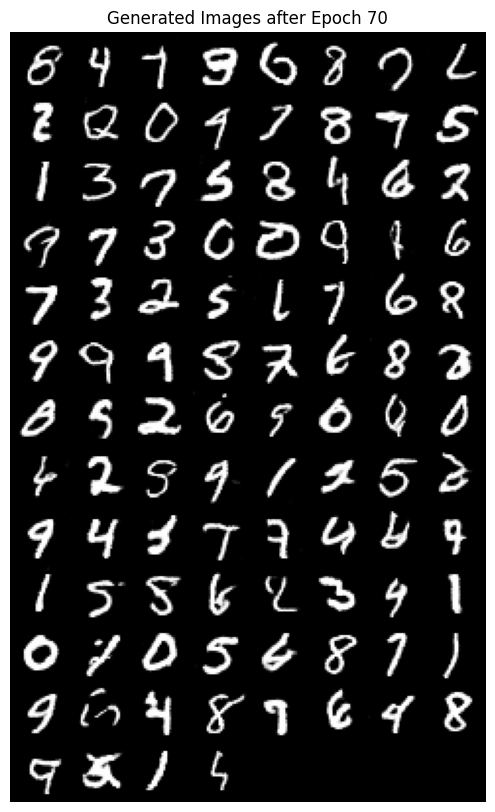

Epoch [71/100], Step [100/600], d_loss: 1.4808, g_loss: 0.9232, D(x): 0.44, D(G(z)): 0.45
Epoch [71/100], Step [200/600], d_loss: 1.2481, g_loss: 0.8279, D(x): 0.45, D(G(z)): 0.34
Epoch [71/100], Step [300/600], d_loss: 1.3479, g_loss: 0.9147, D(x): 0.46, D(G(z)): 0.41
Epoch [71/100], Step [400/600], d_loss: 1.2208, g_loss: 0.9889, D(x): 0.53, D(G(z)): 0.40
Epoch [71/100], Step [500/600], d_loss: 1.3653, g_loss: 0.8357, D(x): 0.43, D(G(z)): 0.39
Epoch [71/100], Step [600/600], d_loss: 1.2972, g_loss: 0.8011, D(x): 0.48, D(G(z)): 0.41
Epoch [72/100], Step [100/600], d_loss: 1.3145, g_loss: 0.9204, D(x): 0.51, D(G(z)): 0.43
Epoch [72/100], Step [200/600], d_loss: 1.2509, g_loss: 0.8326, D(x): 0.48, D(G(z)): 0.37
Epoch [72/100], Step [300/600], d_loss: 1.3230, g_loss: 1.0535, D(x): 0.52, D(G(z)): 0.46
Epoch [72/100], Step [400/600], d_loss: 1.3103, g_loss: 0.7664, D(x): 0.41, D(G(z)): 0.33
Epoch [72/100], Step [500/600], d_loss: 1.4066, g_loss: 0.7940, D(x): 0.44, D(G(z)): 0.43
Epoch [72/

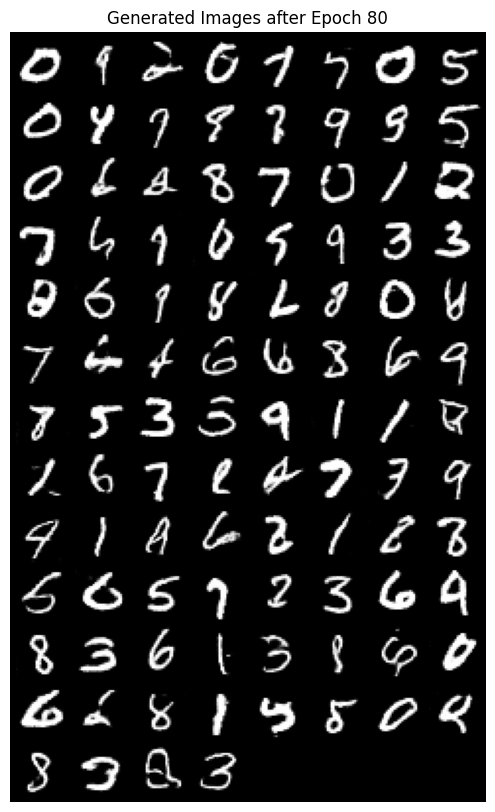

Epoch [81/100], Step [100/600], d_loss: 1.2781, g_loss: 0.9114, D(x): 0.45, D(G(z)): 0.35
Epoch [81/100], Step [200/600], d_loss: 1.2421, g_loss: 0.8025, D(x): 0.48, D(G(z)): 0.37
Epoch [81/100], Step [300/600], d_loss: 1.2921, g_loss: 0.9436, D(x): 0.47, D(G(z)): 0.39
Epoch [81/100], Step [400/600], d_loss: 1.4220, g_loss: 0.9996, D(x): 0.39, D(G(z)): 0.38
Epoch [81/100], Step [500/600], d_loss: 1.3992, g_loss: 0.7909, D(x): 0.45, D(G(z)): 0.43
Epoch [81/100], Step [600/600], d_loss: 1.3829, g_loss: 0.8613, D(x): 0.45, D(G(z)): 0.41
Epoch [82/100], Step [100/600], d_loss: 1.3099, g_loss: 0.9543, D(x): 0.45, D(G(z)): 0.38
Epoch [82/100], Step [200/600], d_loss: 1.2642, g_loss: 0.9383, D(x): 0.50, D(G(z)): 0.40
Epoch [82/100], Step [300/600], d_loss: 1.3579, g_loss: 0.7517, D(x): 0.43, D(G(z)): 0.39
Epoch [82/100], Step [400/600], d_loss: 1.3460, g_loss: 0.9142, D(x): 0.48, D(G(z)): 0.43
Epoch [82/100], Step [500/600], d_loss: 1.4149, g_loss: 1.0396, D(x): 0.46, D(G(z)): 0.45
Epoch [82/

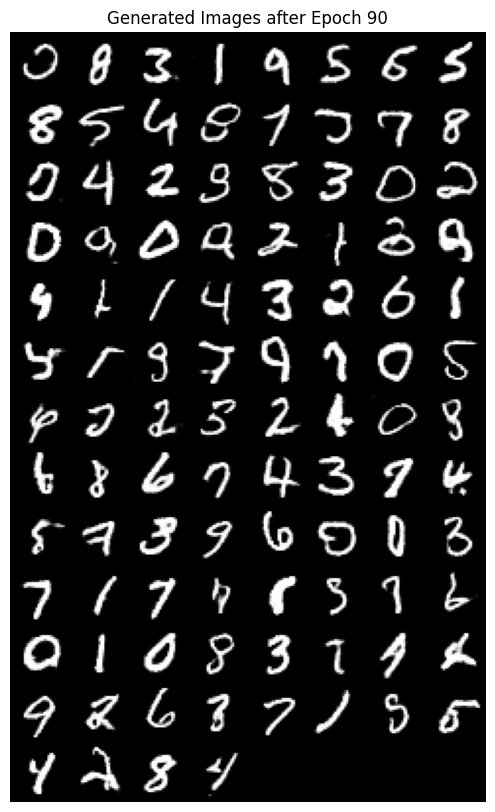

Epoch [91/100], Step [100/600], d_loss: 1.3226, g_loss: 0.8923, D(x): 0.45, D(G(z)): 0.38
Epoch [91/100], Step [200/600], d_loss: 1.3815, g_loss: 0.8109, D(x): 0.48, D(G(z)): 0.45
Epoch [91/100], Step [300/600], d_loss: 1.3526, g_loss: 0.7898, D(x): 0.44, D(G(z)): 0.39
Epoch [91/100], Step [400/600], d_loss: 1.3668, g_loss: 0.9694, D(x): 0.47, D(G(z)): 0.43
Epoch [91/100], Step [500/600], d_loss: 1.3701, g_loss: 0.8002, D(x): 0.49, D(G(z)): 0.45
Epoch [91/100], Step [600/600], d_loss: 1.3108, g_loss: 1.0694, D(x): 0.49, D(G(z)): 0.42
Epoch [92/100], Step [100/600], d_loss: 1.3542, g_loss: 0.8804, D(x): 0.42, D(G(z)): 0.37
Epoch [92/100], Step [200/600], d_loss: 1.4260, g_loss: 0.8982, D(x): 0.48, D(G(z)): 0.47
Epoch [92/100], Step [300/600], d_loss: 1.3580, g_loss: 0.9632, D(x): 0.50, D(G(z)): 0.46
Epoch [92/100], Step [400/600], d_loss: 1.2208, g_loss: 1.0179, D(x): 0.52, D(G(z)): 0.41
Epoch [92/100], Step [500/600], d_loss: 1.2854, g_loss: 1.0839, D(x): 0.49, D(G(z)): 0.41
Epoch [92/

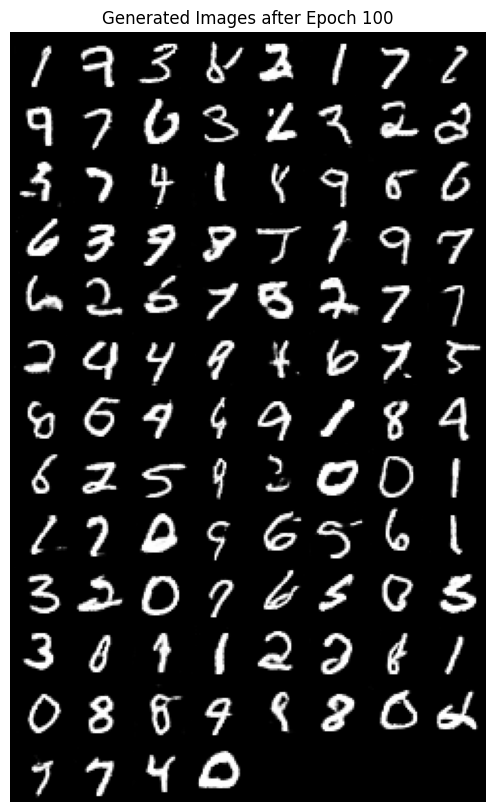

In [ ]:
# Step 7: Training Loop with Visualization
import torchvision.utils as vutils  # Importing utility for visualizing images in a grid

G_losses = []  # List to store generator losses
D_losses = []  # List to store discriminator losses
display_interval = 10  # Display generated images every 10 epochs

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)  # Move images to device

        # Train Discriminator
        optimizer_d.zero_grad()  # Zero the gradients of the discriminator
        outputs = discriminator(images)  # Pass real images through discriminator
        d_loss_real = criterion(outputs, real_labels)  # Compute loss for real images
        real_score = outputs  # Save the discriminator score for real images

        z = torch.randn(batch_size, 100).to(device)  # Generate random noise
        fake_images = generator(z)  # Generate fake images using generator

        outputs = discriminator(fake_images.detach())  # Pass generated images through discriminator
        d_loss_fake = criterion(outputs, fake_labels)  # Compute loss for fake images
        fake_score = outputs  # Save the discriminator score for fake images

        d_loss = d_loss_real + d_loss_fake  # Total discriminator loss
        d_loss.backward()  # Compute gradients
        optimizer_d.step()  # Update discriminator parameters

        # Train Generator
        optimizer_g.zero_grad()  # Zero the gradients of the generator
        outputs = discriminator(fake_images)  # Pass generated images through discriminator
        g_loss = criterion(outputs, real_labels)  # Generator tries to fool discriminator
        g_loss.backward()  # Compute gradients
        optimizer_g.step()  # Update generator parameters

        # Save the losses for plotting
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())

        # Print the losses and scores
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # At the end of each display_interval epoch, show a grid of generated images
    if (epoch + 1) % display_interval == 0 or epoch == num_epochs - 1:
        # Generate a batch of fake images
        z = torch.randn(batch_size, 100).to(device)
        fake_images = generator(z)

        # Display the generated images in a grid
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.title(f'Generated Images after Epoch {epoch+1}')
        plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()


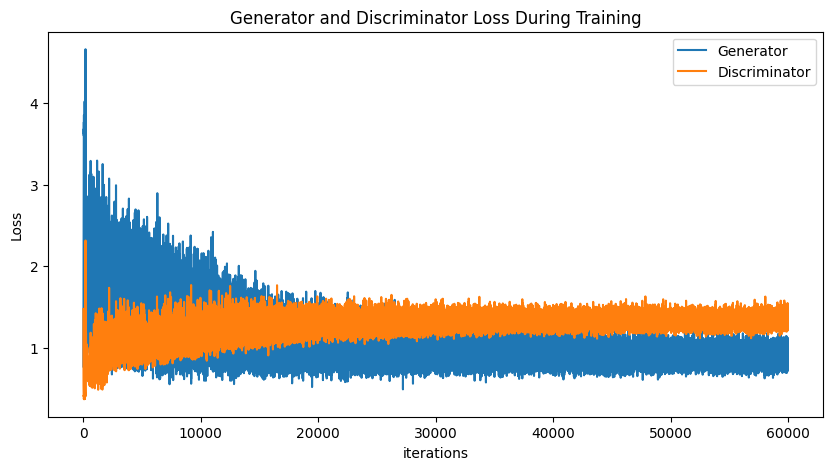

In [ ]:
# Plot the losses of the Generator and the Discriminator during the training of GAN
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

This visualization serves as a diagnostic tool to understand and interpret the behavior and performance of GANs during training.

- Convergence: If the losses are decreasing and stabilize, it may indicate that the network is converging.
- Mode Collapse: If the generator loss is decreasing but the discriminator loss is increasing, it may indicate mode collapse.
- Training Dynamics: The relative magnitude and trends of the losses can provide insights into the adversarial training dynamics between the generator and the discriminator.
- Stability: Observing fluctuations and spikes in the losses can provide insights into the stability of the GAN training process.


In [ ]:
# Step 8: Evaluation using Frechet Inception Distance (FID)
from scipy.linalg import sqrtm
import itertools
from torchvision import transforms
from torchvision.models import inception_v3
from torchvision.transforms import functional as F
from PIL import Image

def torch_cov(m, y=None):
    if y is not None:
        m = torch.cat((m, y), dim=0)
    m_exp = torch.mean(m, dim=0)
    x = m - m_exp
    cov = 1 / (x.size(0) - 1) * x.t().mm(x)
    return cov


# Load pre-trained Inception model + higher level layers
inception_model = inception_v3(pretrained=True)
inception_model = inception_model.to(device)
inception_model.eval()

# Set up the transforms
to_pil_image = transforms.ToPILImage()
to_tensor = transforms.ToTensor()
resize = transforms.Resize((299, 299))

# Define function to convert a tensor to a PIL Image
def tensor_to_pil(img_tensor):
    img_tensor = img_tensor.cpu()
    img = to_pil_image(img_tensor)
    return img

def calculate_fid(images1, images2):
    # Convert images to feature vectors
    act1 = []
    act2 = []
    for img1, img2 in zip(images1, images2):
        img1 = transforms.Compose([transforms.Grayscale(num_output_channels=3), resize, transforms.ToTensor()])(img1).unsqueeze(0).to(device)
        img2 = transforms.Compose([transforms.Grayscale(num_output_channels=3), resize, transforms.ToTensor()])(img2).unsqueeze(0).to(device)

        # Normalize images
        img1 = F.normalize(img1, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        img2 = F.normalize(img2, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

        # Get features
        with torch.no_grad():
            act1.append(inception_model(img1)[0].view(-1).cpu())  # Move to CPU
            act2.append(inception_model(img2)[0].view(-1).cpu())  # Move to CPU

    # Convert list of tensors to a single tensor
    act1 = torch.stack(act1)
    act2 = torch.stack(act2)

    # Calculate FID
    mu1, sigma1 = act1.mean(0), torch_cov(act1)
    mu2, sigma2 = act2.mean(0), torch_cov(act2)

    ssdiff = torch.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm((sigma1 @ sigma2).numpy())  # Corrected line
    covmean = covmean.real
    fid = ssdiff + torch.trace(sigma1 + sigma2 - 2.0 * torch.tensor(covmean, device=act1.device))  # Convert back to tensor

    return fid.item()



# Get images from the data loader and generator
real_images = [tensor_to_pil(img[0]) for img, _ in itertools.islice(data_loader, 100)]  # Take 100 real images
generator.eval()  # Set the generator to evaluation mode
fake_images = [tensor_to_pil(generator(torch.randn(1, 100).to(device))[0]) for _ in range(100)]  # Generate 100 fake images

# Calculate FID
fid_value = calculate_fid(real_images, fake_images)
print(f'Frechet Inception Distance: {fid_value}')


Frechet Inception Distance: 162.1742401123047


##Inception Score (IS)

IS is a widely used metric for evaluating the performance of generative models, specifically in tasks related to image generation, such as those created by Generative Adversarial Networks (GANs). It provides insights into both the quality and diversity of the generated images.

A higher Inception Score indicates that the model is able to generate more diverse and high-quality images, while a lower score might suggest a lack of diversity or lower quality in the generated images. Additionally, the standard deviation of the Inception Score across different generated batches provides insights into the consistency of the model's performance.

In the given code, the Inception Score is calculated for a set of images generated by a model, providing a quantitative measure of the model's generative capabilities. It is crucial for refining and comparing the performance of different generative models in the domain of computer vision.

In [ ]:
# Evaluating Generative Models using Inception Score

import torch.nn.functional as F
from torchvision.models import inception_v3
import numpy as np
from torch.nn.functional import interpolate

# Load the pre-trained Inception v3 model
inception_model = inception_v3(pretrained=True, transform_input=False, aux_logits=True).to(device)
inception_model.eval()

def inception_score(imgs, num_splits=10):
    """
    Computes the Inception Score of the generated images.

    Args:
    imgs (torch.Tensor): Tensor of the generated images.
    num_splits (int): Number of splits for calculating the inception score.

    Returns:
    float: The computed Inception Score.
    """
    # Upsample images to be compatible with the Inception model
    imgs_upsampled = interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)

    # Convert single channel images to 3-channel by repeating the channels
    imgs_upsampled = imgs_upsampled.repeat(1, 3, 1, 1)

    # Get the probability distribution for each image
    with torch.no_grad():
        logits = inception_model(imgs_upsampled)  # Assuming you have fixed the aux_logits argument

    # Convert logits to probabilities
    logits = logits.view(logits.shape[0], -1)  # Reshape logits to 2D if they are not
    probs = F.softmax(logits, dim=1).cpu().numpy()  # Use correct dimension index

    # Compute the inception score
    scores = []
    for i in range(num_splits):
        part = probs[(i * len(probs) // num_splits):((i + 1) * len(probs) // num_splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))

    return np.mean(scores), np.std(scores)


# fake_images should have shape (batch_size, 1, 28, 28) and pixel values in range [0, 1]

# Calculate Inception Score
mean_is, std_is = inception_score(fake_images)
print(f"Inception Score: {mean_is}, Standard Deviation: {std_is}")


Inception Score: 2.108063220977783, Standard Deviation: 0.26128071546554565


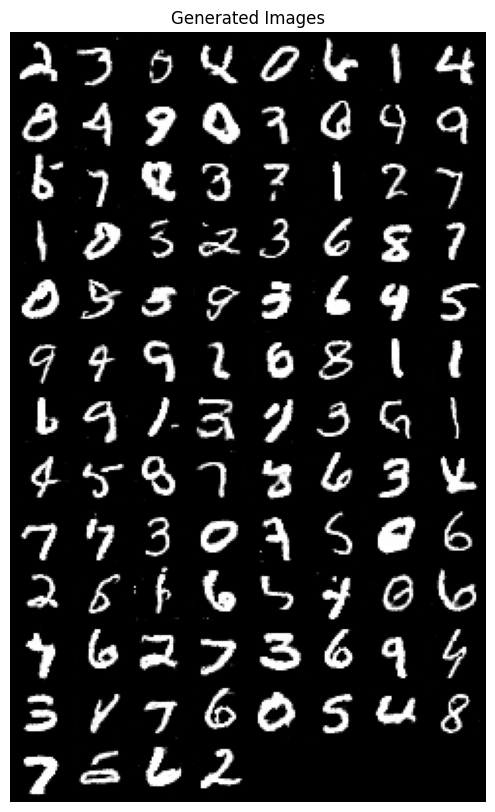

In [ ]:
# Step 9: Visual Inspection of Generated Images
import torchvision.utils as vutils

# Generate a batch of fake images
z = torch.randn(batch_size, 100).to(device)
fake_images = generator(z)

# Display the generated images
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()
